In [1]:
############################################################################################
# IMPORTS
############################################################################################
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

#import tensorflow.keras.backend as K
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay


import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
#import tensorflow.keras as keras

from tensorflow.keras import layers
from tensorflow.keras import regularizers


from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical



from IPython import display
from PIL import Image


import pathlib
import shutil
import tempfile
import concurrent

import pickle
import visualkeras

import json
import glob

#import panel as pn
import streamlit
import joblib


print(tf.config.list_physical_devices())
print('Streamlit ver.: ' + streamlit.__version__)
print('SciKit-learn ver.: ' + sklearn.__version__)
print('TensorFlow ver.: ' + tf.__version__)
print('Joblib ver.: ' + joblib.__version__)

gpu_dev = tf.config.experimental.list_physical_devices('GPU')
for itm in gpu_dev:
    tf.config.experimental.set_memory_growth(itm, True)
############################################################################################

2025-01-15 18:08:26.864773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736960906.894915   56004 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736960906.903938   56004 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 18:08:26.933929: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Streamlit ver.: 1.41.1
SciKit-learn ver.: 1.5.1
TensorFlow ver.: 2.18.0
Joblib ver.: 1.4.2


In [2]:
############################################################################################
# 1.0 CONSTANTS
############################################################################################
TREE_MODEL = './models/final/random_forest_model.pkl'
LAYER_2 = './models/final/Nadine_food-101-EfNetB3-A0.__-earlystop-E__of45-B32_softCat_v1.1b.keras'
SEED = 111
TABLE = './data/food-101/Final_table_dish_info.csv'

TEST_MODEL = './models/final/6_7_final_classification101_EfficientNet.keras'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
############################################################################################
# 1.1 FUNCTIONS
############################################################################################

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    ## First, we create a model that maps the input image to the activations
    ## of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    ## Then, we compute the gradient of the top predicted class for our input image
    ## for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    ## We are doing transfer learning on last layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    ## This is a vector where each entry is the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    ## calculates a heatmap highlighting the regions of importance in an image
    ## for a specific 
    ## predicted class by combining the output of the last convolutional layer
    ## with the pooled gradients.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## For visualization purpose
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img, heatmap, alpha=0.4):
    ## Loading the original image
    img = tf.keras.utils.img_to_array(img)

    ## Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    ## Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    ## Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    ## Superimpose the heatmap on original image
    Superimposed_img = jet_heatmap * alpha + img
    Superimposed_img = tf.keras.utils.array_to_img(Superimposed_img)

    ## Displaying Grad CAM
    plt.imshow(Superimposed_img)
    plt.show()


In [4]:
############################################################################################
# 2.0 TABLE LOAD
############################################################################################
data_df = pd.read_csv(TABLE)
data_df.columns = [val.lower().strip().replace(' ','_') for val in data_df.columns.tolist()]

############################################################################################
# 2.1 MODELS LOAD
############################################################################################
layer_1_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
layer_1_tree = joblib.load(TREE_MODEL)

layer_2 = tf.keras.models.load_model(LAYER_2)

I0000 00:00:1736960910.536212   56004 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5456 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1


In [5]:
############################################################################################
# 3.0 IMAGE LOAD
############################################################################################

#image_path = './data/test_apple_pie_image.jpg'
#image_path = './data/pizza.jpg'
#image_path = './data/railroad_train.jpg'
#image_path = './data/sandwich.jpg'
image_path = './data/sushi.jpg'

img_full = tf.keras.utils.load_img(image_path)

img_l1 = tf.keras.utils.load_img(image_path, target_size=(224, 224))
img_array_l1 = tf.keras.utils.img_to_array(img_l1)

img_l2 = tf.keras.utils.load_img(image_path, target_size=(300, 300))
img_array_l2 = tf.keras.utils.img_to_array(img_l2)

In [6]:
############################################################################################
# 3.1 LAYER 1 PREDICT
############################################################################################
# Extract features using ResNet50
features = layer_1_base.predict(tf.keras.applications.resnet.preprocess_input(np.expand_dims(img_array_l1, axis=0))) # Get feature predictions
# Make a prediction using Random Forest
prediction = layer_1_tree.predict(features.reshape(1, -1))

l1_prob = prediction
l1_label = "Food" if prediction[0] == 0 else "Non-Food" # Interpret the prediction

I0000 00:00:1736960921.742170   56099 service.cc:148] XLA service 0x745ea8003b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736960921.742200   56099 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 with Max-Q Design, Compute Capability 6.1
2025-01-15 18:08:41.883355: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736960922.651364   56099 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-01-15 18:08:43.301631: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


I0000 00:00:1736960925.827385   56099 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
print(f"Predicted class: {l1_label}.")

Predicted class: Food.


In [8]:
############################################################################################
# 3.2 LAYER 2 PREDICT
############################################################################################

pred_l2 = layer_2.predict(tf.keras.preprocessing.image.smart_resize(tf.expand_dims(img_array_l2, axis=0), size=(300,300)))
l2_label = str(data_df.dish_name[np.argmax(pred_l2, axis = -1)].astype(str).values)
l2_prob = pred_l2.max()

2025-01-15 18:08:52.986006: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:378] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


Predicted class: ['sushi'], probability: 0.9999993.


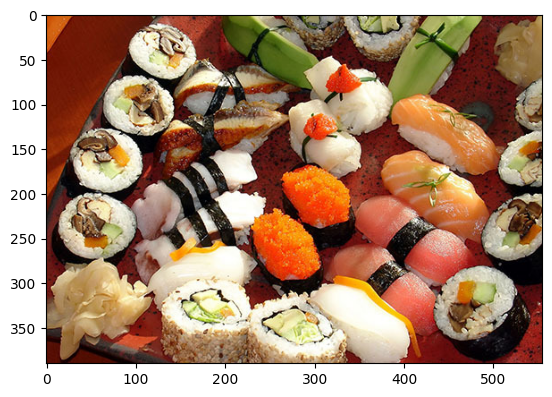

2025-01-15 18:08:57.230896: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


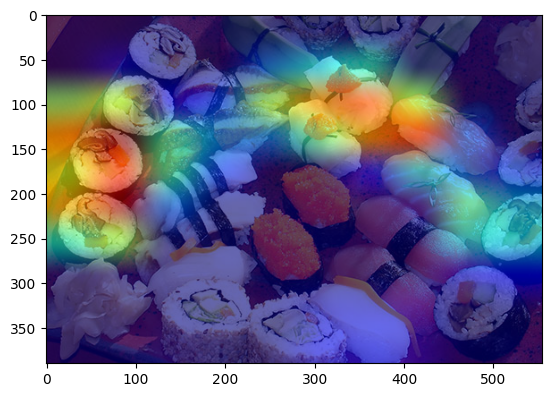

In [9]:
############################################################################################
# 4. IMAGE and GRADCAM HEATMAP SHOW
############################################################################################
print(f'Predicted class: {str(l2_label)}, probability: {str(l2_prob)}.')
plt.imshow(img_full)
plt.show()
heatmap = make_gradcam_heatmap(img_array=tf.expand_dims(img_array_l2, axis=0), model=layer_2, last_conv_layer_name=layer_2.layers[6].name)
#plt.matshow(heatmap)
#plt.show()
display_gradcam(img=img_full, heatmap=heatmap, alpha=1.5)

In [22]:
data_df

,dish_name,main_ingredients,optional_ingredients,all_allergens,dietary_status,countries,nutrients_per_100g,proteins,fats,carbs,classic_recipe
0,apple_pie,"Apples, flour, butter","Cinnamon, sugar","Milk, Wheat",Vegetarian,"USA, GBR",237 kcal,3g protein,10g fat,34g carbs,"Apples 300g, Flour 200g, Butter 100g; Time: 75..."
1,baby_back_ribs,"Pork ribs, BBQ sauce","Honey, garlic",Honey,Non-Vegetarian,USA,300 kcal,25g protein,20g fat,5g carbs,"Pork ribs 500g, BBQ sauce 100g; Time: 150 minutes"
2,baklava,"Phyllo dough, nuts, honey","Cinnamon, cardamom","Nuts, Wheat, Honey",Vegetarian,"TUR, GRC",430 kcal,4g protein,21g fat,56g carbs,"Phyllo dough 200g, Nuts 150g, Honey 100g; Time..."
3,beef_carpaccio,"Beef, olive oil, parmesan","Lemon, capers","Milk, Citrus",Non-Vegetarian,ITA,175 kcal,19g protein,9g fat,1g carbs,"Beef 200g, Olive oil 20ml, Parmesan 30g; Time:..."
4,beef_tartare,"Raw beef, egg yolk","Mustard, capers","Eggs, Mustard",Non-Vegetarian,"FRA, DEU",200 kcal,18g protein,14g fat,0g carbs,"Raw beef 150g, Egg yolk 1, Mustard 10g; Time: ..."
...,...,...,...,...,...,...,...,...,...,...,...
96,tacos,"Tortilla, meat, cheese","Lettuce, salsa","Milk, Wheat",Non-Vegetarian,MEX,250 kcal,10g protein,12g fat,25g carbs,"Tortilla 200g, Meat 150g, Cheese 50g; Time: 25..."
97,takoyaki,"Octopus, batter, mayo","Bonito flakes, seaweed","Shellfish, Wheat, Eggs, Soy",Non-Vegetarian,JPN,300 kcal,8g protein,15g fat,30g carbs,"Octopus 100g, Batter 200g, Mayo 50g; Time: 30 ..."
98,tiramisu,"Mascarpone, coffee, ladyfingers",Cocoa powder,"Milk, Wheat, Eggs, Chocolate",Vegetarian,ITA,350 kcal,7g protein,20g fat,40g carbs,"Mascarpone 200g, Coffee 50ml, Ladyfingers 100g..."
99,tuna_tartare,"Tuna, avocado, soy sauce",Sesame oil,"Fish, Soy, Sesame",Non-Vegetarian,FRA,150 kcal,20g protein,5g fat,5g carbs,"Tuna 200g, Avocado 50g, Soy sauce 20ml; Time: ..."


In [42]:
data_df.at[int(np.argmax(pred_l2, axis = -1)), 'dish_name']


'sushi'

In [51]:
probable_labels = []
probable_cert = []


for itr in range(5):
            probable_labels.append( str(data_df.at[int(np.argmax(pred_l2, axis = -1)), 'dish_name']) )
            probable_cert.append(pred_l2.max()*100)
            pred_l2 = np.delete(pred_l2, np.argmax(pred_l2, axis = -1))
            print(f"{probable_labels[itr]}, probab. {probable_cert[itr]}")


sushi, probab. 99.99992847442627
sashimi, probab. 3.2314136433342355e-05
cup_cakes, probab. 1.4118187152689643e-05
deviled_eggs, probab. 9.35329111939609e-06
cannoli, probab. 5.693219762292756e-06


In [52]:
        for itr in range(5):
            probable_labels.append( str(data_df.at[int(np.argmax(pred_l2, axis = -1)), 'dish_name']) )
            probable_cert.append(pred_l2.max()*100)
            pred_l2 = np.delete(pred_l2, np.argmax(pred_l2, axis = -1))
            streamlit.write(f"{probable_labels[itr]}, probability {probable_cert[itr].round(4)}")

2025-01-15 18:33:06.924 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-15 18:33:07.013 
  command:

    streamlit run /home/dima/DSML/UMAMI/.venv/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-01-15 18:33:07.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-15 18:33:07.015 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-15 18:33:07.016 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-15 18:33:07.017 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-15 18:33:07.019 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-15 18:33:07.020 Thread 'M